<font face = 'Computer Modern', size = 4>

To Do:

<ul>
<li> Keep this notebook pretty </li>
<li> Figure out *explainable variance* </li>
<li> Cross validate on $\alpha$, # of PC's, # of history terms for ridge regression
    <ul>
        <li> With history filter </li>
        <li> With running speed filter </li>
    </ul>
    </li>
<li> Determine if non-linearity helps (i.e. repeat above with Sigmoid and Exponential non-linearity) </li>
</ul>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glm_model as gm
from glm_utils import *
from scipy.stats import linregress
import pprint
import allensdk.brain_observatory.stimulus_info as stim_info
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import tensorflow as tf

%load_ext autoreload
%autoreload 2
%matplotlib inline

boc = BrainObservatoryCache(manifest_file='boc/manifest.json')

In [2]:
import pandas as pd

# Download experiment containers for VISp experiments, with imaging depth 350 
visp_ecs = boc.get_experiment_containers(targeted_structures=['VISp'], imaging_depths = [350], cre_lines=['Scnn1a-Tg3-Cre'])
print("Experiment containers: %d" % len(visp_ecs))

# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))

# find direction selective cells in VISp
visp_ec_ids = [ ec['id'] for ec in visp_ecs ]
visp_cells = cells[cells['experiment_container_id'].isin(visp_ec_ids)]
print("Layer 4 cells from primary visual cortex: %d" % len(visp_cells))


ns_cells = visp_cells[(visp_cells['p_ns'] < 0.05) & (visp_cells['p_ns'] > 0.0) & 
                      (visp_cells['time_to_peak_ns'] > 0.001) & visp_cells['time_to_peak_ns'] < 1]

print("Cells that with significant response to natural scenes: %d" % len(ns_cells))

Experiment containers: 3
total cells: 18260
Layer 4 cells from primary visual cortex: 923
Cells that with significant response to natural scenes: 340


In [3]:
#just look at cells from the first experiment container
exp = boc.get_ophys_experiments(experiment_container_ids=[visp_ecs[0]['id']], stimuli = [stim_info.NATURAL_SCENES])
data_set = boc.get_ophys_experiment_data(exp[0]['id'])

In [4]:
#get all the traces. 
#WRITE THIS IN A MORE EFFICIENT WAY!!!

from allensdk.brain_observatory.dff import compute_dff


dff_dict = {}

for cell_s in data_set.get_cell_specimen_ids():
    for cell_can in ns_cells['cell_specimen_id']:
        if cell_s == cell_can:
            time, corrected_traces = data_set.get_corrected_fluorescence_traces(cell_specimen_ids=[cell_s])
            dff_dict[cell_s] = np.squeeze(compute_dff(np.array(corrected_traces))[0])# read in the array of images

            

#get the stimulus
scenes = data_set.get_stimulus_template('natural_scenes')
stim_table = data_set.get_stimulus_table(stim_info.NATURAL_SCENES)

In [5]:
from sklearn.decomposition import PCA

model = PCA()
scenes_r = model.fit_transform(scenes.reshape([len(scenes), -1]))

In [6]:
#declare a dictionary of empty lists for each cell trace, 
#and a list for the stimulus
data = {k: [] for k in dff_dict.keys()}
stim_array = []
im_array = [] #keep track of which image index each stimulus is, so we can check 'explainable variance'

#average each trace over the presentation of each stimulus, and add
#to dictionary with cell id as keys

for index, row in stim_table.iterrows():    
    stim_array.append(scenes_r[row.frame])
    for c in dff_dict.keys():
        data[c].append(np.average(dff_dict[c][row['start']:row['end']]))
    im_array.append(row.frame)
    
stim_array = np.array(stim_array)

In [14]:
#first we do just a ridge regression model
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split
from itertools import product

#hyperparameters to crossvalidate across
n_lag = [1, 2]
alpha = np.linspace(5, 200, num = 50)
n_pcs = range(5, 110, 5)

#empty dictionary of the best model we've fit for each cell
best_model = {k: (-np.inf, None) for k in data.keys()}

#make a dictionary of dictionaries to store the results
scores_dict = {k: {} for k in data.keys()}

for (l, a, n) in product(n_lag, alpha, n_pcs):

    #recreate a stimulus array with the desired lag and number of components
    stim = stim_array[:, 0:n]    
    stim_array_more = []
    for i in range(0, len(stim)):
        if i < l:
            stim_array_more.append(np.zeros([l*stim.shape[1]]))
        else:
            temp = np.squeeze(stim[i-l:i].reshape([-1]))
            stim_array_more.append(temp)
    stim_array_ = np.array(stim_array_more)
    
    for c in data.keys():
        
        #now we fit the ridge regression model with the selected alpha
        X_train, X_test, y_train, y_test = train_test_split(stim_array_, np.array(data[c]))        
        model = Ridge(alpha = a, fit_intercept= True)        
        model.fit(X_train, y_train)
        
        #calculate r2 on both the training and test data
        r2_train = model.score(X_train, y_train)
        r2_test = model.score(X_test, y_test)
        
        scores_dict[c][(l, a, n)] = (r2_test, r2_train) 
        
        if r2_test > best_model[c][0]:
            best_model[c] = (r2_test, (l, a, n))        

<font face= 'Computer Modern' size = 4>

To calculate the explainable variance for each cell, first I calculate the cells mean response to each image, then construct an array the same shape as the cells trace, where each element is it's mean response to the stimulus that was shown. 

I think perform a linear regression of the average response vs. the actual response, and record the $r^2$ of that model.

In [15]:
#let's try this explainable variance dealio

im_array = np.array(im_array)
rishi_alex = {k: [] for k in data.keys()}

av_r = np.zeros_like(data[c])

for c in data.keys():
    dff = np.array(data[c]) 
    for image in range(118):
        idx  = np.where(im_array == image)
        ave = np.mean(dff[idx[0]])        
        av_r[idx] = ave
        
    slope, intercept, r_value, p_value, std_err = linregress(dff, av_r)
    rishi_alex[c] = r_value**2     

0.0256936713077


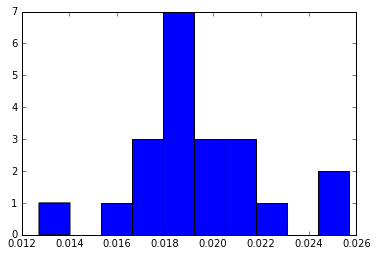

In [16]:
#plot the distribution of "explainable variance"
plt.hist(rishi_alex.values());

print max(rishi_alex.values())

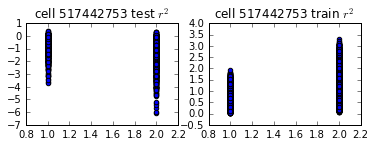

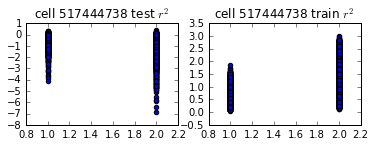

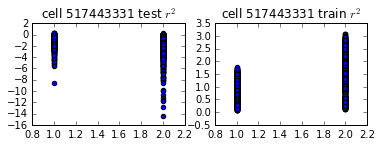

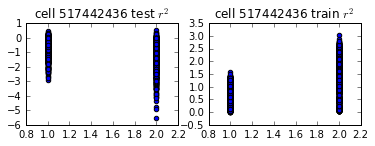

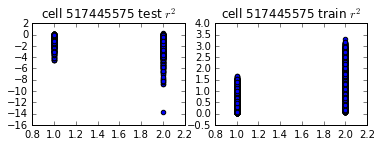

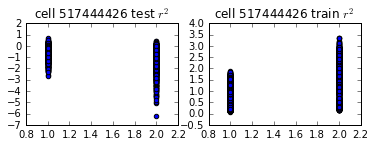

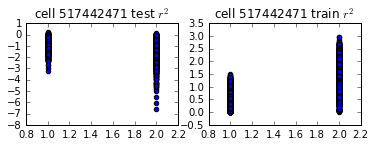

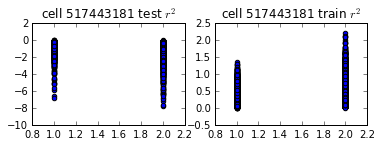

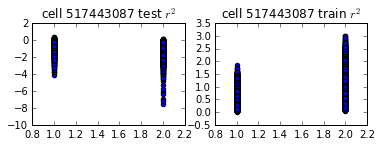

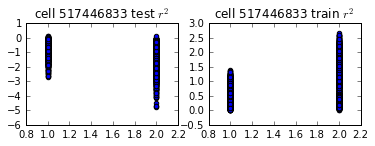

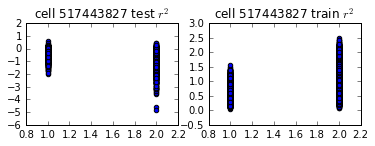

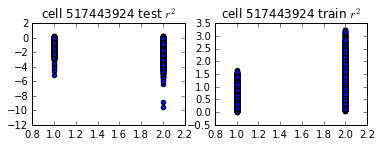

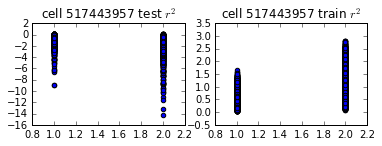

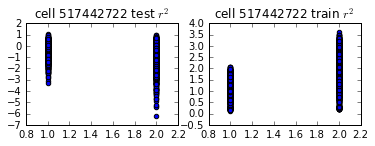

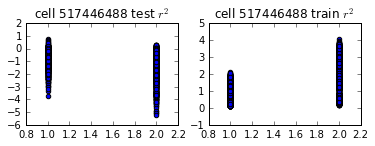

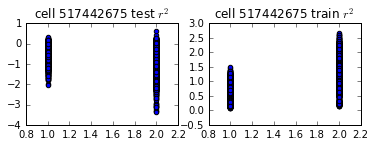

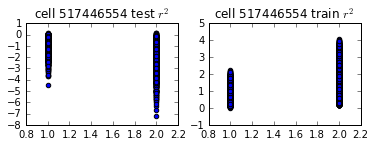

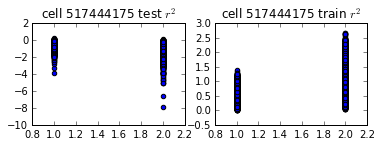

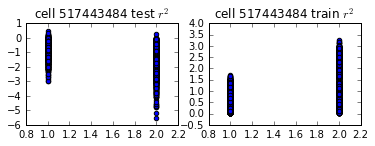

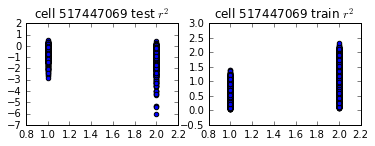

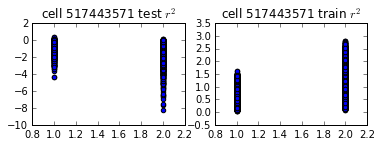

In [17]:
#first let's calculate some aggregate statistics - and plot how explained variance goes with lag for each cell
for c in data.keys():
    
    ra_var = rishi_alex[c]
    
    plt.subplot(221)
    for (l, a, n) in scores_dict[c].keys():
        plt.scatter(l, scores_dict[c][(l, a, n)][0] / ra_var)
     
    plt.title('cell ' + str(c) + ' test $r^2$')
    
    plt.subplot(222)   
    for (l, a, n) in scores_dict[c].keys():
        plt.scatter(l, scores_dict[c][(l, a, n)][1] / ra_var)
     
    plt.title('cell ' + str(c) + ' train $r^2$')
    plt.show()
  

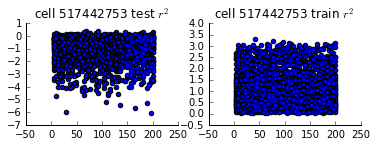

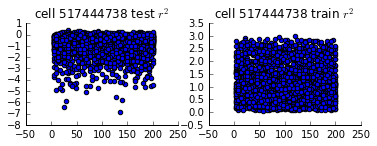

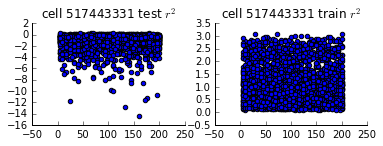

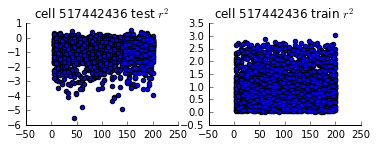

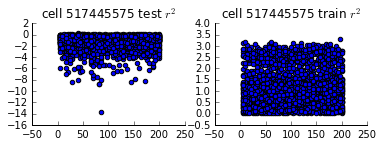

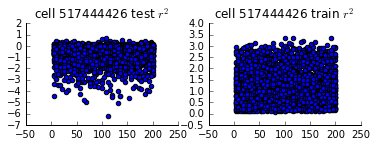

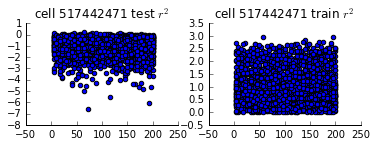

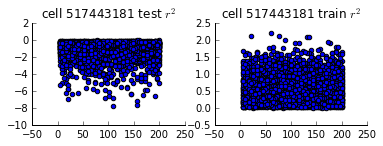

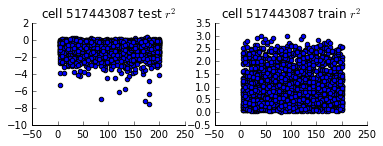

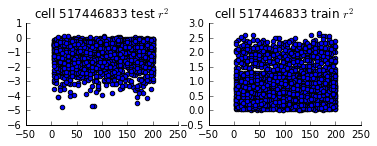

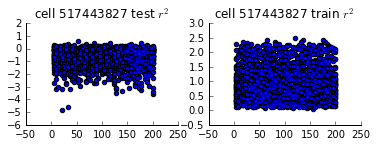

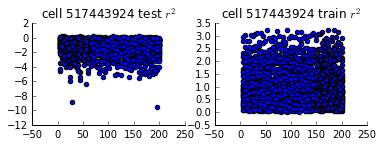

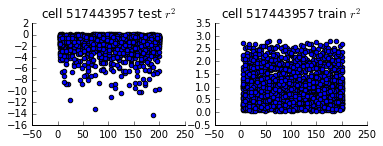

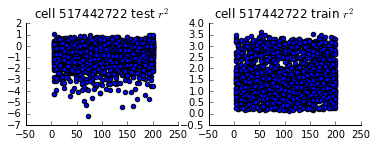

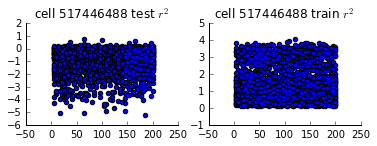

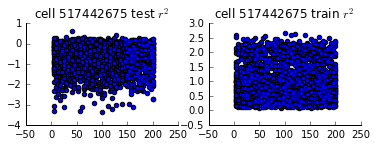

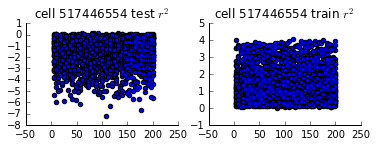

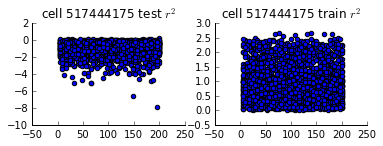

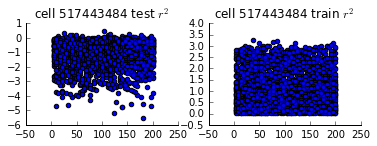

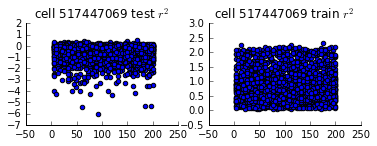

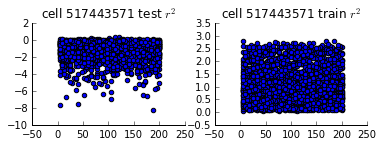

In [24]:
#first let's calculate some aggregate statistics - and plot how explained variance goes with lag for each cell
for c in data.keys():
    
    ra_var = rishi_alex[c]
    
    ax = plt.subplot(221)
    for (l, a, n) in scores_dict[c].keys():
        plt.scatter(a, scores_dict[c][(l, a, n)][0] / ra_var)
    
    simpleaxis(ax)
    plt.title('cell ' + str(c) + ' test $r^2$')
    
    ax = plt.subplot(222)   
    for (l, a, n) in scores_dict[c].keys():
        plt.scatter(a, scores_dict[c][(l, a, n)][1] / ra_var)
    
    simpleaxis(ax)
    plt.title('cell ' + str(c) + ' train $r^2$')
    plt.show() 

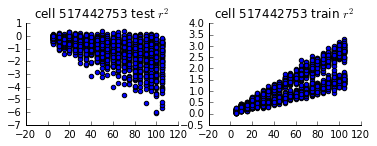

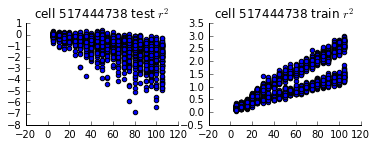

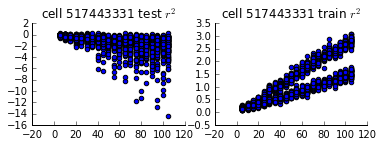

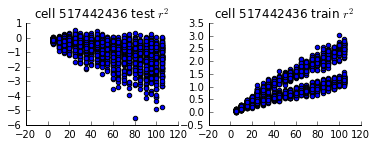

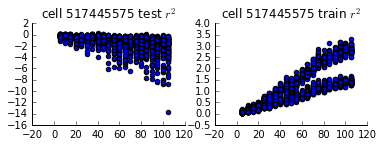

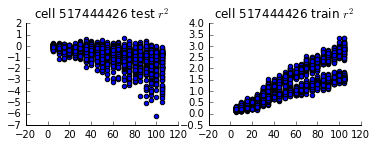

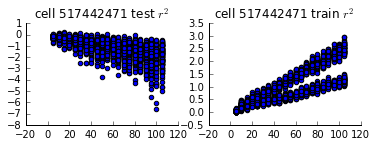

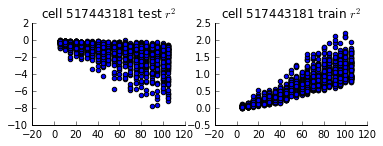

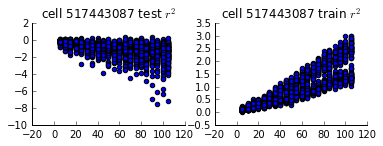

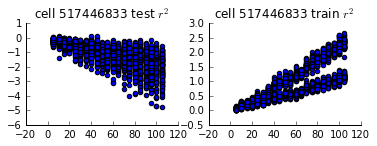

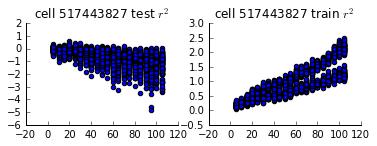

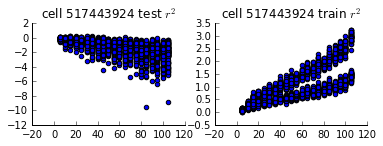

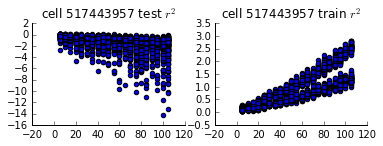

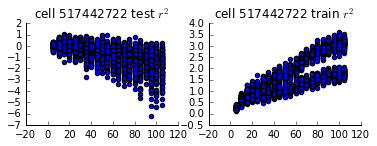

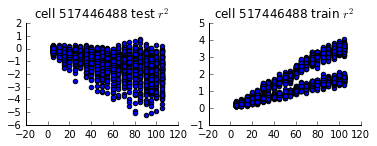

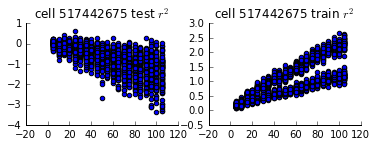

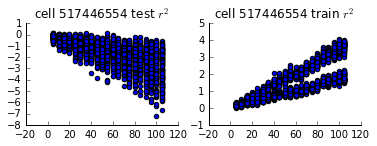

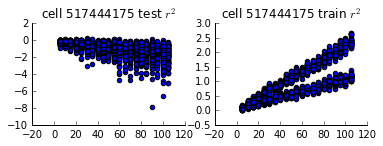

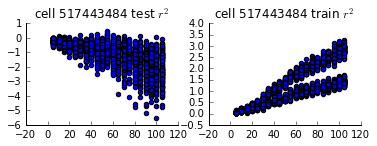

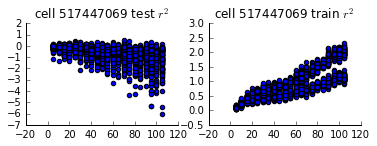

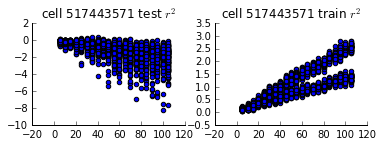

In [23]:
#first let's calculate some aggregate statistics - and plot how explained variance goes with number of principal components for each cell
for c in data.keys():
    
    ra_var = rishi_alex[c]
    
    ax =  plt.subplot(221)
    for (l, a, n) in scores_dict[c].keys():
        plt.scatter(n, scores_dict[c][(l, a, n)][0] / ra_var)
    
    simpleaxis(ax) 
    plt.title('cell ' + str(c) + ' test $r^2$')
    
    ax = plt.subplot(222)   
    for (l, a, n) in scores_dict[c].keys():
        plt.scatter(n, scores_dict[c][(l, a, n)][1] / ra_var)
    
    simpleaxis(ax) 
    plt.title('cell ' + str(c) + ' train $r^2$')
    plt.show()

<font face = 'Computer Modern', size = 4>

From the above it's obvious both that the models are overfitting, and that things are fairly consistant from cell to cell. 

let's see what the best model parameters were!


In [20]:
for c in data.keys():
    ra_var = rishi_alex[c]
    (v, (l, a, n)) = best_model[c]
    print 'explained var: ', round(v, 2), 'ra var:', round(v/ra_var, 2), 'n_lags:', l,'alpha:', round(a, 2), 'n_components', n

explained var:  0.01 ra var: 0.41 n_lags: 1 alpha: 68.67 n_components 70
explained var:  0.01 ra var: 0.38 n_lags: 2 alpha: 32.86 n_components 50
explained var:  0.01 ra var: 0.3 n_lags: 1 alpha: 44.8 n_components 35
explained var:  0.01 ra var: 0.53 n_lags: 2 alpha: 156.22 n_components 25
explained var:  0.0 ra var: 0.25 n_lags: 2 alpha: 40.82 n_components 40
explained var:  0.01 ra var: 0.7 n_lags: 1 alpha: 108.47 n_components 70
explained var:  0.0 ra var: 0.25 n_lags: 1 alpha: 64.69 n_components 15
explained var:  0.0 ra var: 0.06 n_lags: 1 alpha: 76.63 n_components 65
explained var:  0.01 ra var: 0.41 n_lags: 1 alpha: 176.12 n_components 90
explained var:  0.0 ra var: 0.15 n_lags: 1 alpha: 32.86 n_components 40
explained var:  0.02 ra var: 0.6 n_lags: 1 alpha: 52.76 n_components 20
explained var:  0.0 ra var: 0.28 n_lags: 1 alpha: 160.2 n_components 30
explained var:  0.0 ra var: 0.15 n_lags: 1 alpha: 156.22 n_components 45
explained var:  0.02 ra var: 1.01 n_lags: 1 alpha: 5.0 n_

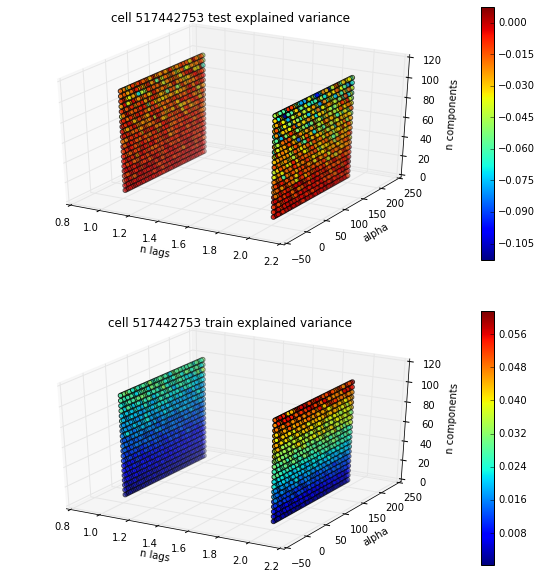

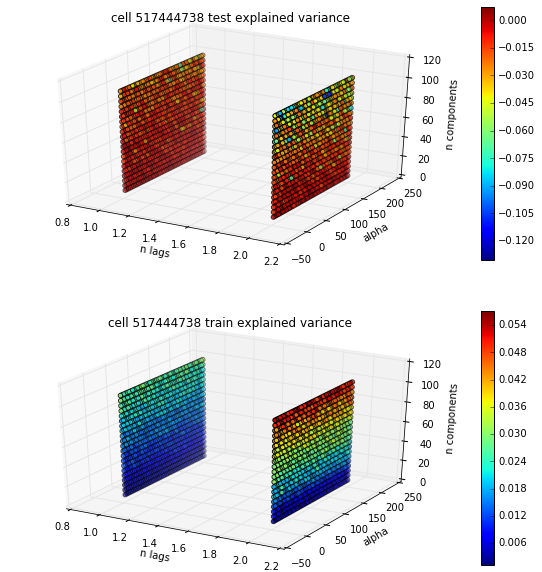

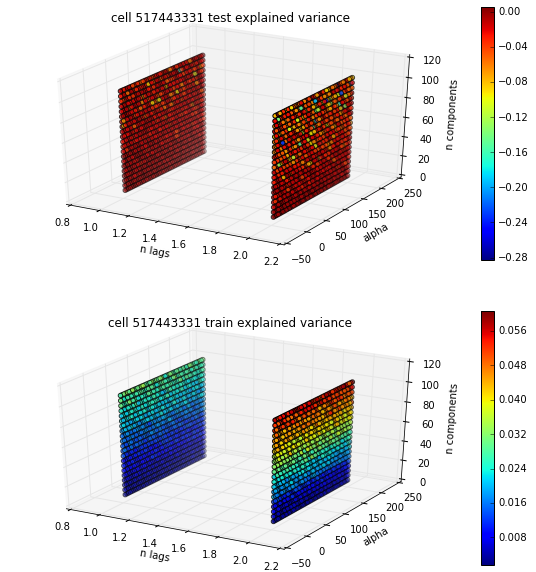

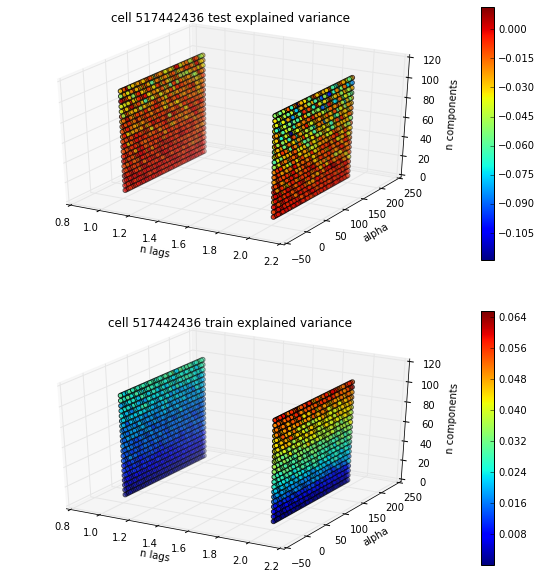

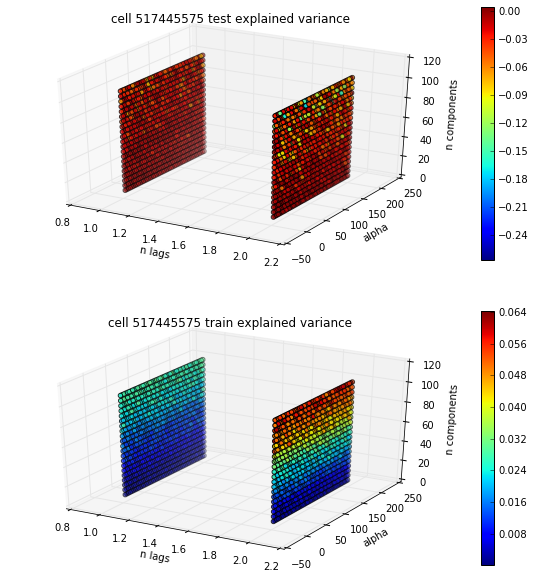

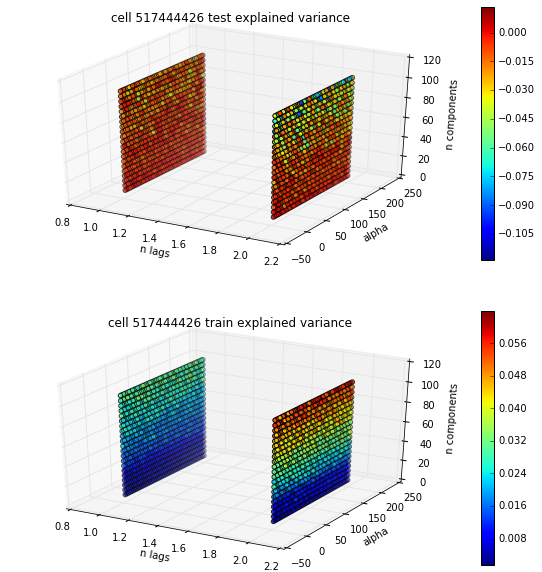

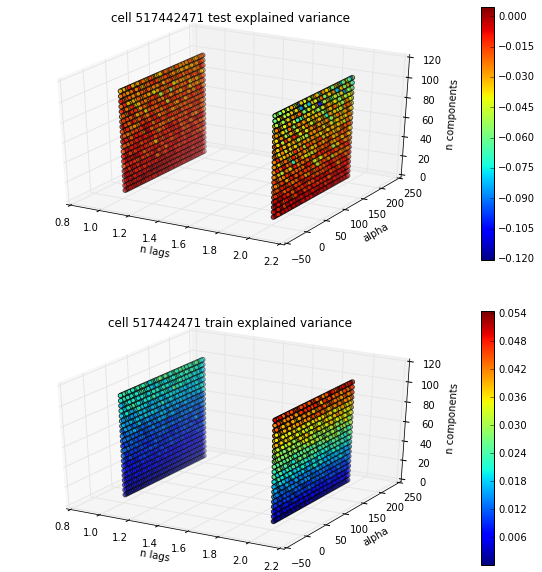

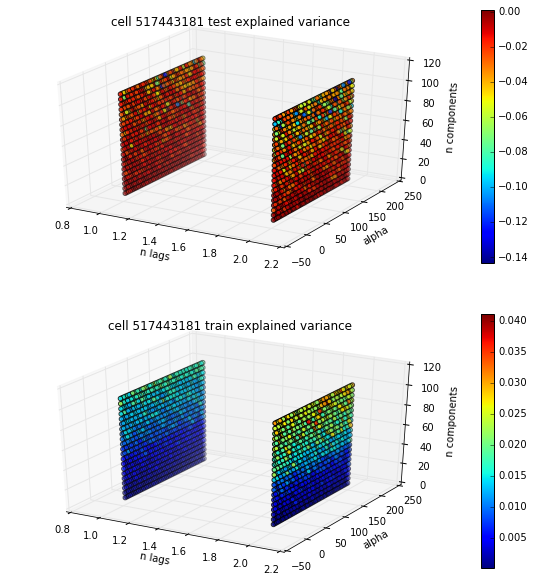

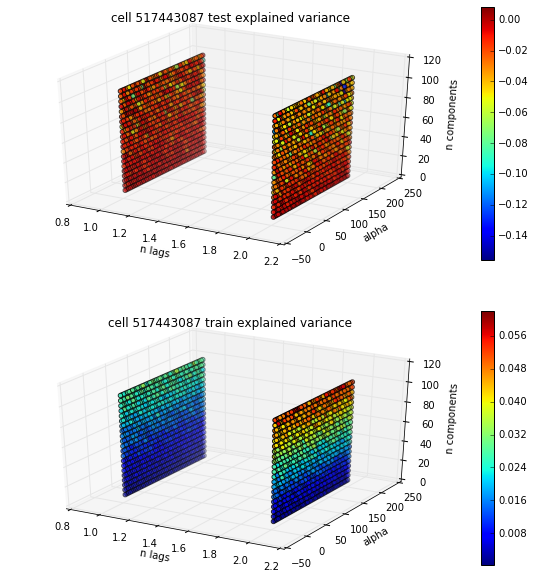

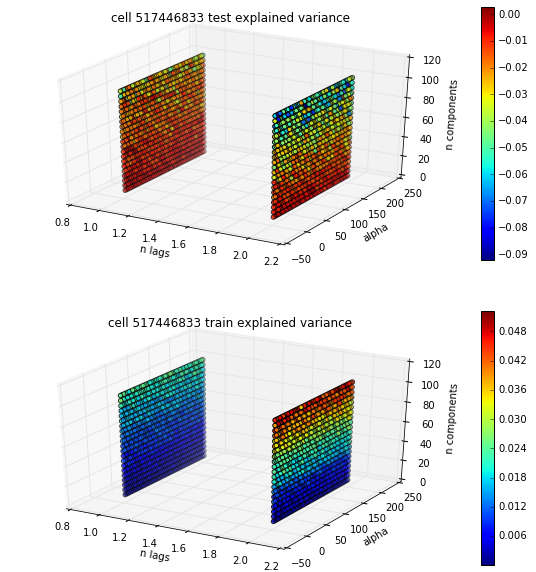

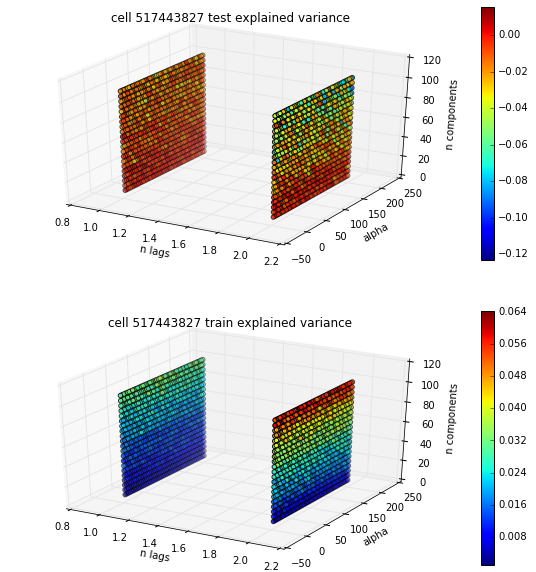

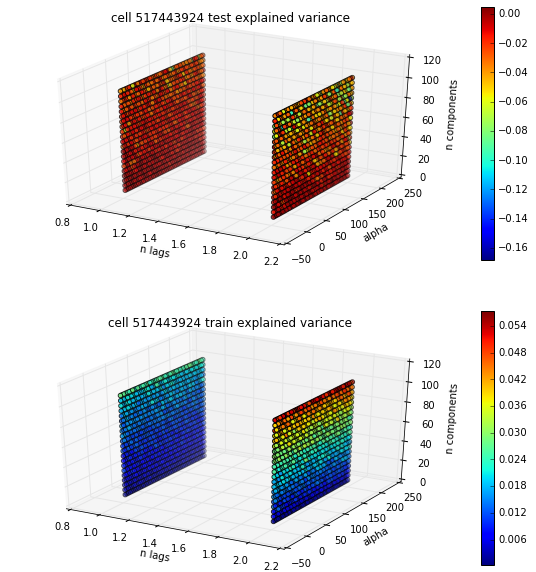

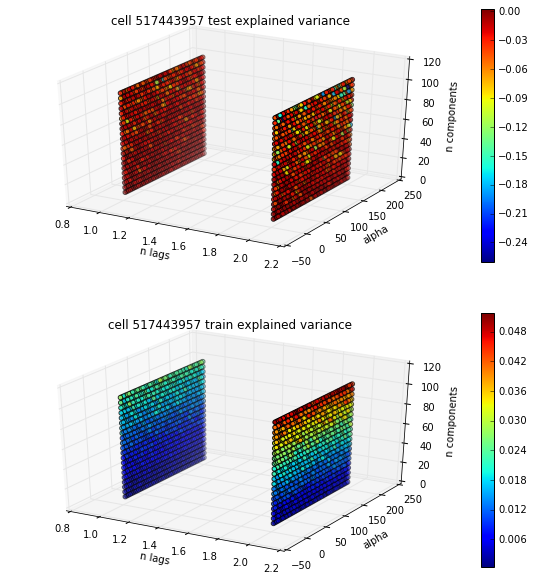

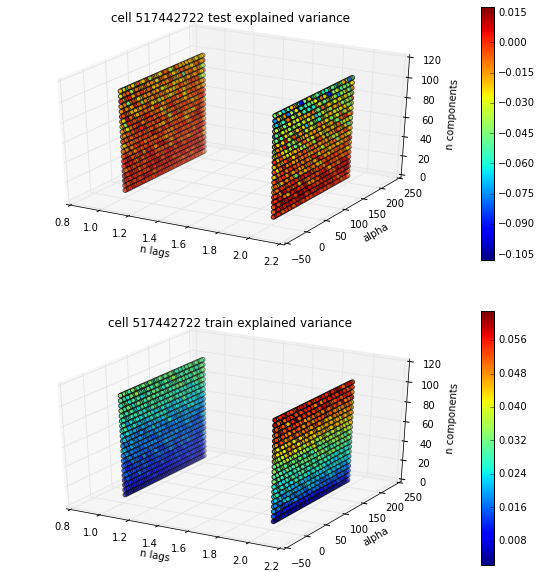

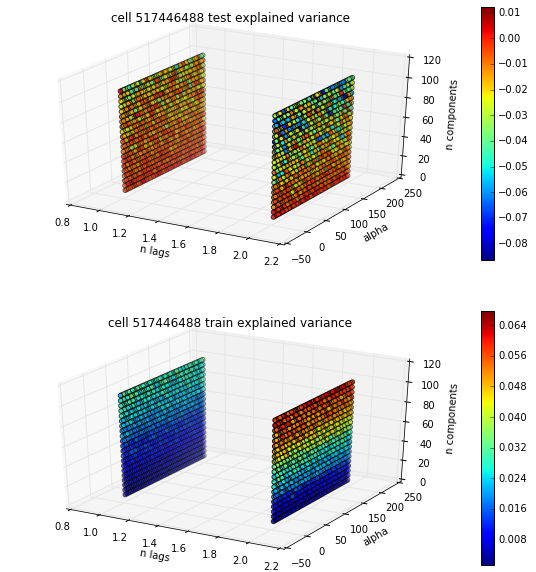

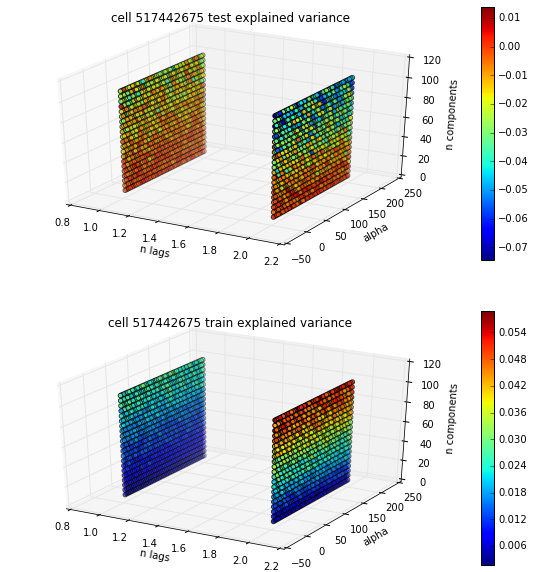

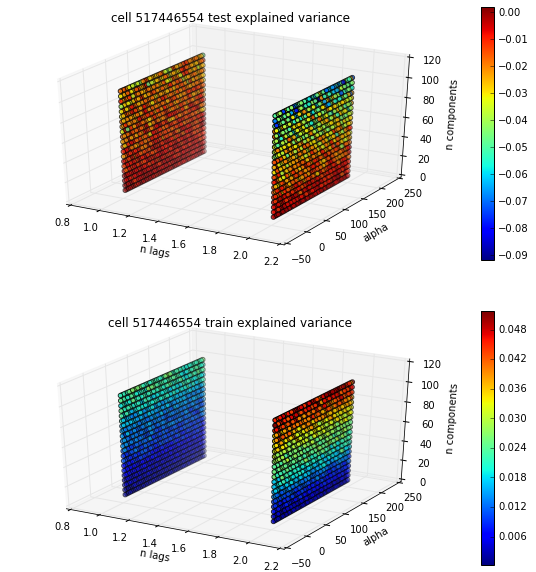

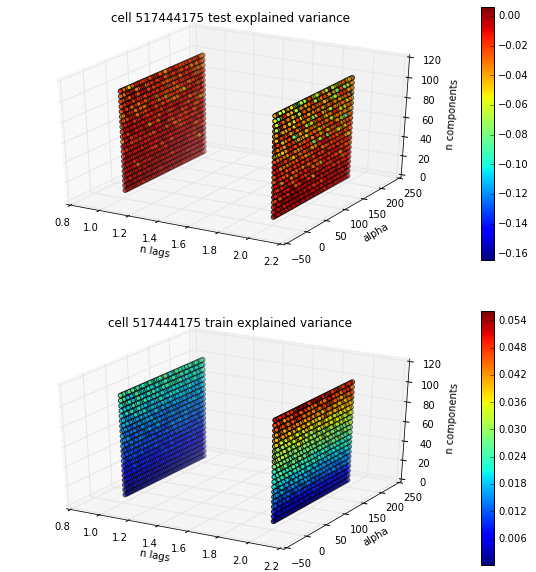

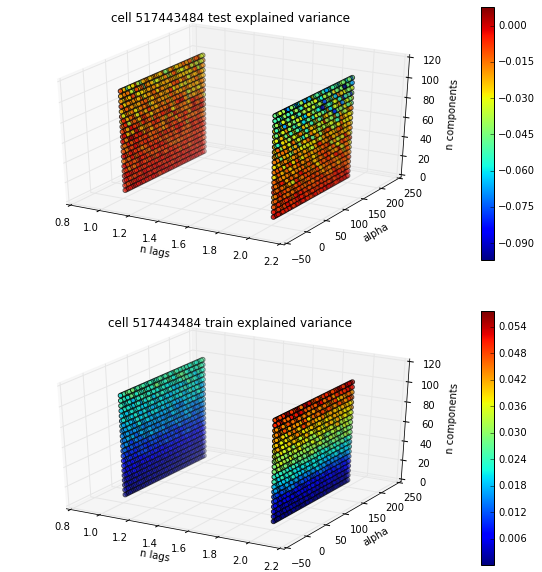

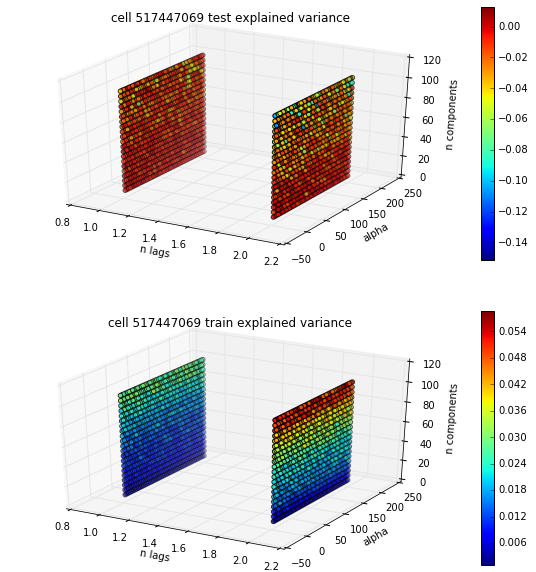

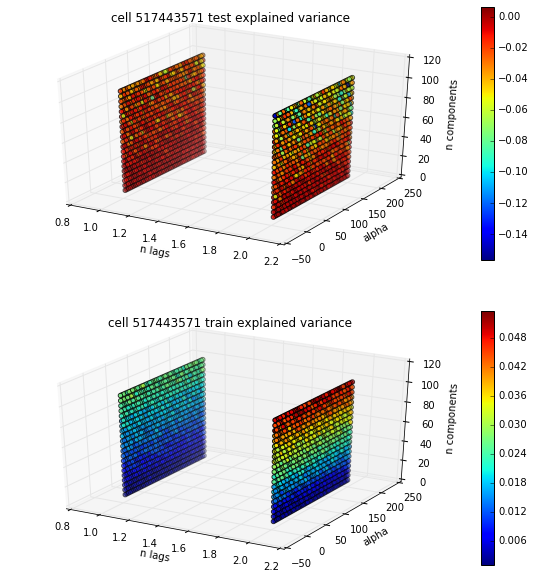

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


for c in data.keys():

    lags = []
    al = []
    ncomp = []
    rtest =[]
    rtrain = []

    for (l, a, n) in scores_dict[c].keys():
        lags.append(l)
        al.append(a)
        ncomp.append(n)
        rtest.append(scores_dict[c][(l, a, n)][0])
        rtrain.append(scores_dict[c][(l, a, n)][1])



    fig = plt.figure(figsize = (10, 10))

    ax = fig.add_subplot(211, projection='3d')

    im = ax.scatter(lags, al, ncomp, c  = rtest)
    ax.set_xlabel('n lags')
    ax.set_ylabel('alpha')
    ax.set_zlabel('n components')
    ax.set_title('cell ' + str(c) + ' test explained variance')

    fig.colorbar(im)


    ax = fig.add_subplot(212, projection='3d')
    im = ax.scatter(lags, al, ncomp, c  = rtrain)
    ax.set_xlabel('n lags')
    ax.set_ylabel('alpha')
    ax.set_zlabel('n components')
    ax.set_title('cell ' + str(c) + ' train explained variance')
    fig.colorbar(im)

    plt.show()

In [22]:
len(dff_dict.keys())

21